In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms

In [2]:
BATCH_SIZE = 1
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "model_resnet50.pth"

In [3]:
test_data_path = "data/Train"
data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
])
test_data = datasets.ImageFolder(root = test_data_path, transform = data_transforms)
# test_loader = data.DataLoader(test_data, shuffle=False, batch_size=1)
test_loader = data.DataLoader(test_data, shuffle=False)

In [4]:
class Net(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, output_dim)
        )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
# model = Net(43).to(device)

from torchvision.models.resnet import resnet50
model=resnet50(pretrained=True)
model.fc=nn.Linear(2048, 43)
model.to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

In [8]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    
    for data, target in tqdm(test_loader):
        
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        
        if init_pred.item() != target.item():
            continue
            
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        
        final_pred = output.max(1, keepdim=True)[1]
        
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples
    

In [ ]:
# test(model, device, test_loader, 0.3)
accuracies = []
examples = []
# epsilons = [0.05]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

  0%|          | 0/39209 [00:00<?, ?it/s]/home/xiaolong/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 1/39209 [00:00<1:08:06,  9.59it/s]

Epsilon: 0	Test Accuracy = 36556 / 39209 = 0.9323369634522686


  0%|          | 1/39209 [00:00<1:05:52,  9.92it/s]

Epsilon: 0.05	Test Accuracy = 5029 / 39209 = 0.12826136856334006


  0%|          | 1/39209 [00:00<1:05:37,  9.96it/s]

Epsilon: 0.1	Test Accuracy = 2713 / 39209 = 0.06919329745721646


 21%|██        | 8204/39209 [13:08<52:02,  9.93it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [25]:
def read_image(path):
#     img = Image.open(path).convert("RGB")
    img = Image.open(path).convert("RGB")
    
    transform = transforms.Compose([
        transforms.Resize([112, 112]),
        transforms.ToTensor(),
#         Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    tensor_ = transform(img)
#     print(tensor_.shape)
    tensor = tensor_.unsqueeze(0)

    return tensor

def to_array(tensor):

    tensor_ = tensor.squeeze()

    unnormalize_transform = transforms.Compose([
        Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])
    ])
    arr_ = unnormalize_transform(tensor_)
    arr = arr_.permute(1, 2, 0).detach().numpy()

    return arr

In [35]:
tensor = read_image("data/Train/1/00001_00000_00012.png")
tensor = read_image("examples/1_4.jpg")
# tensor = tensor.squeeze()
# tensor = read_image("data/train/0/00000_00000_00001.png")
tensor = tensor.to(device)
print(tensor.shape)
output = model(tensor)

final_pred = output.max(1, keepdim=True)[1]

final_pred.item()

torch.Size([1, 3, 112, 112])


1

In [67]:
tensor = read_image("examples/1_0.jp")
tensor = tensor.to(device)
print(tensor.shape)
output = model(tensor)

final_pred = output.max(1, keepdim=True)[1]

final_pred.item()

torch.Size([3, 112, 112])
torch.Size([1, 3, 112, 112])


18

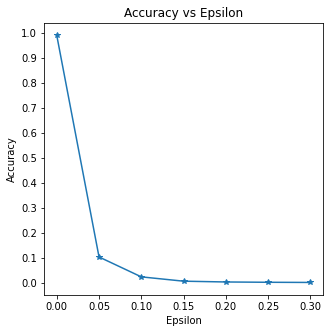

In [52]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

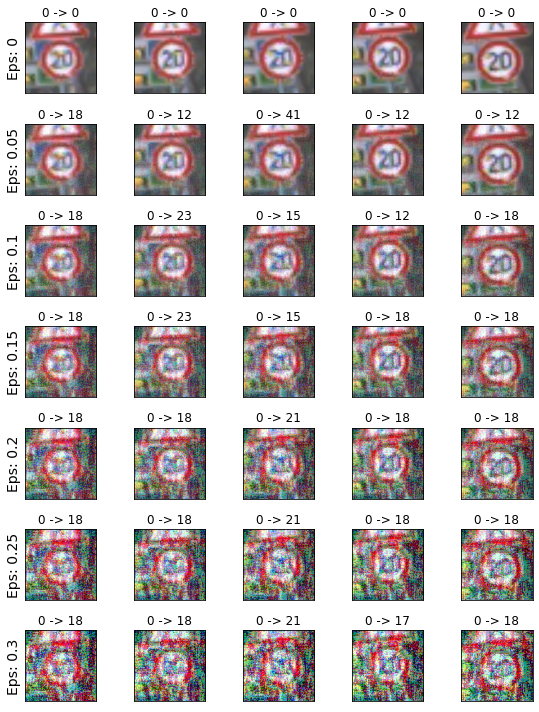

In [66]:
import cv2
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
#         cv2.imwrite("examples/{}_{}.jpg".format(i, j), ex)
        ex = np.transpose(ex, (1,2,0))
        plt.imsave('examples/{}_{}.jpg'.format(i, j), ex)
        plt.imshow(ex)
        
plt.tight_layout()
plt.show()

In [63]:
! rm -r *_*.jpg

In [130]:
from PIL import Image

from torch.autograd import Variable

data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
])

img = Image.open("data/train/0/00000_00000_00000.png")
# test_data = datasets.ImageFolder(root = test_data_path, transform = data_transforms)
test_loader = data.DataLoader(img, shuffle=False, batch_size=1)

for data, target in test_loader:
    print(data)

# img = Image.open("data/train/0/00000_00000_00000.png")
# img = data_transforms(img)
# # img = Variable(img[None, ...])
# img.to(device)
# print(device)
# print(img.shape)
# # img = np.array(img)
# # img = np.array([img])
# # print(img.shape)
# # img = data_transforms(img)
# # img = Variable(torch.unsqueeze(img, dim=0).float(), requires_grad=False)
# # print(img.shape)

# # img.to(device)
# output = model(img)

TypeError: object of type 'PngImageFile' has no len()

In [76]:
from PIL import Image
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        orig,adv,ex = examples[i][j]
        ex = np.transpose(ex, (1,2,0))
#         print(ex)
        ex = np.array([ex])
        ex = Image.fromarray(ex.astype('uint8')).convert('RGB')
#         print(orig, adv, ex)
        ex = data_transforms(ex)
#         ex = np.array([ex])
        ex.to(device)
        data.requires_grad = True
        output = model(ex)

TypeError: Cannot handle this data type: (1, 1, 112, 3), |u1